# Part I

## Question 1

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Load the data (dimaond dataset)

In [29]:
raw_df = pd.read_csv("diamonds.csv")
raw_df = raw_df.drop(columns=["Unnamed: 0"])

#### numerical encoding for categorical features

In [30]:
cut_raw_to_num = {
    "Fair": 1,
    "Good": 2,
    "Very Good": 3,
    "Premium": 4,
    "Ideal": 5
}
color_raw_to_num = {
    "J": 1,
    "I": 2,
    "H": 3,
    "G": 4,
    "F": 5,
    "E": 6,
    "D": 7,
}
clarity_raw_to_num = {
    "I1": 1,
    "SI2": 2,
    "SI1": 3,
    "VS2": 4,
    "VS1": 5,
    "VVS2": 6,
    "VVS1": 7,
    "IF": 8
}
all_raw_to_num = {
    **cut_raw_to_num,
    **color_raw_to_num,
    **clarity_raw_to_num
}

In [32]:
df = raw_df.replace(all_raw_to_num)

### Question 1.1

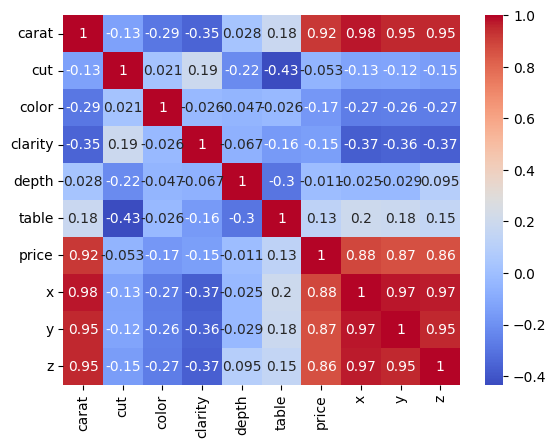

In [56]:
q1_1_corr = df.corr(method='pearson')
sns.heatmap(q1_1_corr, annot=True, cmap="coolwarm")
plt.show()

In [57]:
q1_1_highest = q1_1_corr['price'].abs().sort_values(ascending=False).index[1]
print("Feature with highest absolute correlation with the target variable: " + q1_1_highest)

Feature with highest absolute correlation with the target variable: carat


The correlation pattern suggests strong relationship between weight and size of a dimond and its price.

### Question 1.2

#### Plot of histogram of numerical features (originally)

In [62]:
q1_2_original_num_col = [
    "carat",
    "depth",
    "table",
    "x",
    "y",
    "z"
]

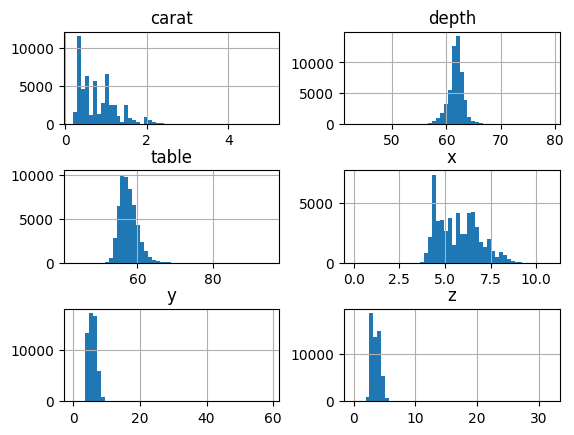

In [81]:
df[q1_2_original_num_col].hist(bins=50)
plt.subplots_adjust(hspace=0.5) 
plt.show()

#### Plot of histogram of numerical features (categorical features converted)

In [85]:
q1_2_categorical_num_col = [
    "cut",
    "color",
    "clarity"
]

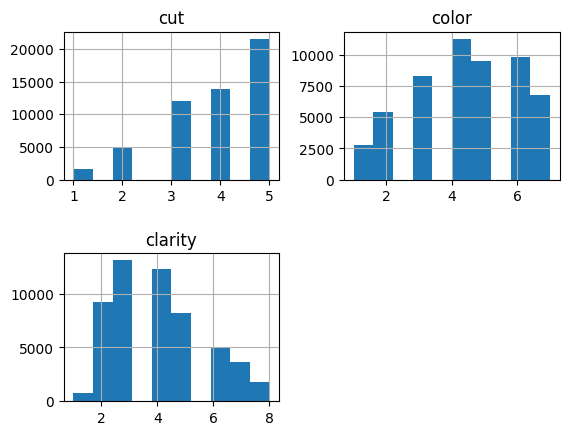

In [87]:
df[q1_2_categorical_num_col].hist()
plt.subplots_adjust(hspace=0.5) 
plt.show()

If the distribution of a feature has high skewness, we can perform:
- square root transformation: take the square root for each value in the feature, this only applies to non negative values which fits our dataset greatly if there is high skewness.

### Question 1.3

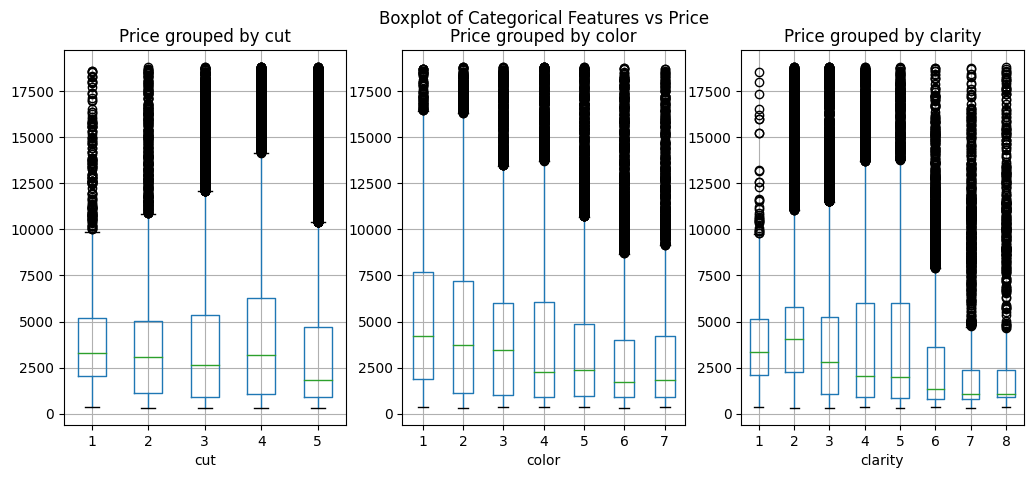

In [296]:
q1_3_cat_col = [
    "cut",
    "color",
    "clarity"
]
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i in range(len(q1_3_cat_col)):
    fet_name = q1_3_cat_col[i]
    df[[fet_name, "price"]].boxplot(by=[fet_name], ax=ax[i])
    ax[i].title.set_text('Price grouped by ' + fet_name)
    ax[i].set_xlabel(fet_name)

fig.suptitle('Boxplot of Categorical Features vs Price')
plt.show()

As we can see from the boxplots above, it's counter intuitive that as cut/color/clarity increases in the better direction, the price actually decreases, however, one important fact is the target feature is price not unit price. We will show later that as three features grows in better direction, the unit price actually increases as we'd expected.

### Question 1.4

#### Plot of counts by color, cut, clarity with original labels

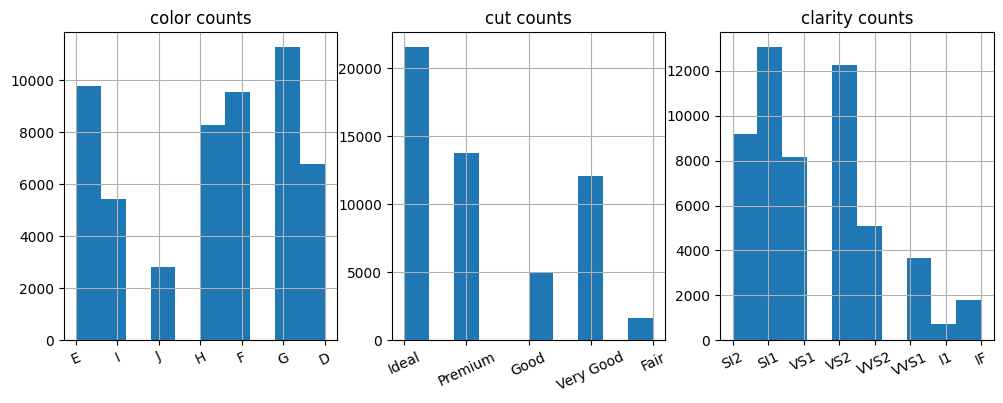

In [297]:
q1_4_cols = ["color", "cut", "clarity"]
fig, ax = plt.subplots(1, len(q1_4_cols), figsize=(12, 4))

for i in range(len(q1_4_cols)):
    raw_df[q1_4_cols[i]].hist(ax=ax[i])
    ax[i].title.set_text(q1_4_cols[i] + " counts")
    ax[i].tick_params("x", labelrotation=25)
    
plt.show()

## Question 2

In [174]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression

### Question 2.1

In [298]:
q2_1_scaler = StandardScaler()
df[q1_2_original_num_col] = q2_1_scaler.fit_transform(df[q1_2_original_num_col])
df[q1_2_categorical_num_col] = q2_1_scaler.fit_transform(df[q1_2_categorical_num_col])

### Question 2.2

#### Mutual Information

In [299]:
q2_2_mut_res = mutual_info_regression(df[q1_2_original_num_col + q1_2_categorical_num_col], df["price"])

In [300]:
pd.DataFrame(list(zip(q1_2_original_num_col + q1_2_categorical_num_col, q2_2_mut_res)),
             columns=["Feature", "Estimated Mutual Information"]).set_index("Feature")

,Estimated Mutual Information
Feature,
carat,1.654883
depth,0.031204
table,0.033624
x,1.412822
y,1.421156
z,1.361312
cut,0.059525
color,0.135376
clarity,0.218647


#### F Score

In [301]:
q2_2_f_score, _ = f_regression(df[q1_2_original_num_col + q1_2_categorical_num_col], df["price"])

In [302]:
pd.DataFrame(list(zip(q1_2_original_num_col + q1_2_categorical_num_col, q2_2_f_score)),
             columns=["Feature", "F Score"]).set_index("Feature")

,F Score
Feature,
carat,304051.486618
depth,6.115863
table,886.119363
x,193741.523066
y,160915.662263
z,154923.266553
cut,154.784468
color,1654.401244
clarity,1188.007065


#### Describe how this step qualitatively affects the performance of your models in terms of test RMSE. Is it true for all model types?

## Training and Testing of Different Models

In [303]:
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.neural_network import MLPRegressor

In [304]:
feat_cols = q1_2_original_num_col + q1_2_categorical_num_col
targ_col = "price"
kfold = KFold(n_splits=10)

In [305]:
def do_model(model, df=df): 
    model.avg_train_rmse = 0
    model.avg_test_rmse = 0
    
    for train_idxs, test_idxs in kfold.split(df):
        
        train = df.iloc[train_idxs]
        train_x = train[feat_cols]
        train_y = train[targ_col]
        test = df.iloc[test_idxs]
        test_x = test[feat_cols]
        test_y = test[targ_col]
    
        model.fit(train_x, train_y)
        model.avg_train_rmse += mean_squared_error(train_y,
                                                  model.predict(train_x),
                                                  squared=False)
        model.avg_test_rmse += mean_squared_error(test_y,
                                                 model.predict(test_x),
                                                 squared=False)
    model.avg_train_rmse /= 10
    model.avg_test_rmse /= 10
    return model

### Linear Regression

#### Ordinary Least Squares regression

In [306]:
ols = do_model(LinearRegression())

#### Lasso regression

In [307]:
lasso = do_model(Lasso())

#### Ridge regression

In [308]:
ridge = do_model(Ridge())

### Question 4.1

In [309]:
pd.DataFrame({
    "Feature": feat_cols,
    "OLS": ols.coef_,
    "Lasso": lasso.coef_,
    "Ridge": ridge.coef_
}).set_index("Feature")

,OLS,Lasso,Ridge
Feature,,,
carat,4961.242492,4917.499012,4958.661802
depth,-112.674924,-109.797256,-112.496651
table,-64.691501,-63.513410,-64.671835
x,-849.383646,-768.153222,-846.296466
y,69.039438,25.700552,68.755558
z,-25.041452,-20.955820,-25.335594
cut,135.377151,135.081718,135.376853
color,566.342397,564.225550,566.258989
clarity,863.182768,863.213119,863.200753


Based on the above data, the absolute value of all coefficients are low for Lasso (L1) regression. It remains similar for Ridge (L2) regression compared with OLS.

### Question 4.2

In [310]:
q4_2_reg_mult = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
q4_2_models = [
    LinearRegression()
] + [
    Lasso(alpha=alpha) for alpha in q4_2_reg_mult
] + [
    Ridge(alpha=alpha) for alpha in q4_2_reg_mult
]
for model in q4_2_models:
    _ = do_model(model)

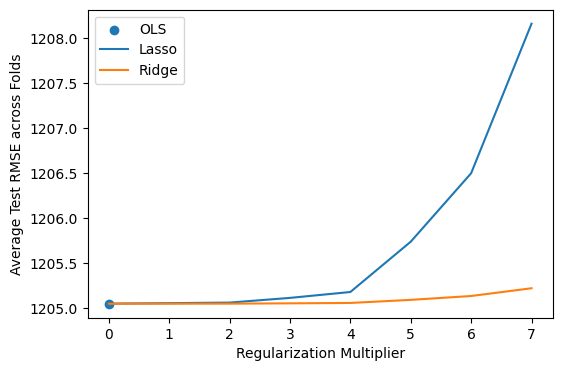

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(0, q4_2_models[0].avg_test_rmse, label="OLS")
x = range(len(q4_2_reg_mult))
ax.plot(x, [model.avg_test_rmse for model in q4_2_models[1:1+len(q4_2_reg_mult)]], label="Lasso")
ax.plot(x, [model.avg_test_rmse for model in q4_2_models[1+len(q4_2_reg_mult):]], label="Ridge")

plt.xlabel("Regularization Multiplier")
plt.ylabel("Average Test RMSE across Folds")

plt.legend()
plt.show()

As we can see in the graph, regularization only increase the RMSE, so the best regularization scheme is no regularization.

### Question 4.3

In [312]:
non_stand_df = raw_df.replace(all_raw_to_num)

In [313]:
q4_3_non_stand_models = [
    do_model(Ridge(alpha=alpha*0.1), non_stand_df) for alpha in range(21)
]
q4_3_stand_models = [
    do_model(Ridge(alpha=alpha*0.1), df) for alpha in range(21)
]

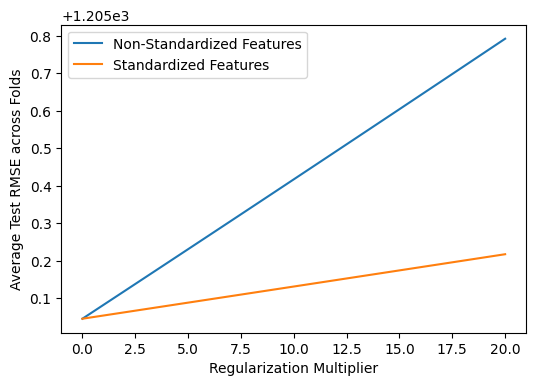

In [314]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

x = range(21)
ax.plot(x, [model.avg_test_rmse for model in q4_3_non_stand_models], label="Non-Standardized Features")
ax.plot(x, [model.avg_test_rmse for model in q4_3_stand_models], label="Standardized Features")

plt.xlabel("Regularization Multiplier")
plt.ylabel("Average Test RMSE across Folds")

plt.legend()
plt.show()

Feature standardization helps performance, but really minor. As we can see in the above plot.

### Question 4.4

### Neural Network

### Question 6.1

In [315]:
q6_1_default_MLP = do_model(MLPRegressor(verbose=False))
q6_1_default_MLP.avg_test_rmse

/Users/jiaxiwang/opt/anaconda3/envs/cs269/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/jiaxiwang/opt/anaconda3/envs/cs269/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/jiaxiwang/opt/anaconda3/envs/cs269/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/jiaxiwang/opt/anaconda3/envs/cs269/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the o

742.8147367319723